# Download dataset
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [137]:
# https://drive.google.com/file/d/1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b/view?usp=drive_link
!gdown --id 1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YJiHQeLotsaXAXCtLLKBHPaawqKiSC5b
To: /content/traffic_sign_detection.zip
100% 229M/229M [00:03<00:00, 64.9MB/s]


In [138]:
!unzip traffic_sign_detection.zip

Archive:  traffic_sign_detection.zip
replace annotations/road0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace annotations/road0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace annotations/road0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: annotations/road0.xml   
  inflating: annotations/road1.xml   
  inflating: annotations/road10.xml  
  inflating: annotations/road100.xml  
  inflating: annotations/road101.xml  
  inflating: annotations/road102.xml  
  inflating: annotations/road103.xml  
  inflating: annotations/road104.xml  
  inflating: annotations/road105.xml  
  inflating: annotations/road106.xml  
  inflating: annotations/road107.xml  
  inflating: annotations/road108.xml  
  inflating: annotations/road109.xml  
  inflating: annotations/road11.xml  
  inflating: annotations/road110.xml  
  inflating: annotations/road111.xml  
  inflating: annotations/road112.xml  
  inflating: annotations/road113.

# Import libraries

In [3]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# I. Build Traffic Sign Classification Model (SVM)

## 1. Read and extract dataset

In [4]:
annotations_dir = 'annotations'
img_dir = 'images'

img_lst = []
label_lst = []
for xml_file in os.listdir(annotations_dir):
    xml_filepath = os.path.join(annotations_dir, xml_file)
    tree = ET.parse(xml_filepath)
    root = tree.getroot()

    folder = root.find('folder').text
    img_filename = root.find('filename').text
    img_filepath = os.path.join(img_dir, img_filename)
    img = cv2.imread(img_filepath)

    for obj in root.findall('object'):
        classname = obj.find('name').text
        if classname == 'trafficlight':
            continue

        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        object_img = img[ymin:ymax, xmin:xmax]
        img_lst.append(object_img)
        label_lst.append(classname)

In [8]:
print('Number of objects: ', len(img_lst))
print('Class names: ', list(set(label_lst)))

Number of objects:  1074
Class names:  ['stop', 'crosswalk', 'speedlimit']


## 2. Preprocess images

In [28]:
def preprocess_img(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.float32)

    resized_img = resize(
        img,
        output_shape=(32, 32),
        anti_aliasing=True
    )

    hog_feature = feature.hog(
        resized_img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        block_norm="L2",
        feature_vector=True
    )

    return hog_feature

In [29]:
img_features_lst = []
for img in img_lst:
    hog_feature = preprocess_img(img)
    img_features_lst.append(hog_feature)

img_features = np.array(img_features_lst)

## 3. Encode label

In [30]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_lst)

## 4. Split train val set

In [32]:
random_state = 0
test_size = 0.3
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_features, encoded_labels,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

## 5. Normalization

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## 6. Training

In [34]:
clf = SVC(
    kernel='rbf',
    random_state=random_state,
    probability=True,
    C=0.5
)
clf.fit(X_train, y_train)

SVC(C=0.5, probability=True, random_state=0)

## 7. Evaluation

In [35]:
y_pred = clf.predict(X_val)
score = accuracy_score(y_pred, y_val)

print('Evaluation results on val set')
print('Accuracy: ', score)

Evaluation results on val set
Accuracy:  0.9814241486068112


# II. Traffic Sign Localization (Sliding Window)

## 1. Create sliding window function

In [67]:
def sliding_window(img, window_sizes, stride, scale_factor):
    img_height, img_width = img.shape[:2]
    windows = []
    for window_size in window_sizes:
        window_width, window_height = window_size
        for ymin in range(0, img_height - window_height + 1, stride):
            for xmin in range(0, img_width - window_width + 1, stride):
                xmax = xmin + window_width
                ymax = ymin + window_height

                windows.append([xmin, ymin, xmax, ymax])

    return windows

## 2. Create pyramid image function

In [114]:
def pyramid(img, scale=0.8, min_size=(30, 30)):
    acc_scale = 1.0
    pyramid_imgs = [(img, acc_scale)]

    i = 0
    while True:
        acc_scale = acc_scale * scale
        h = int(img.shape[0] * acc_scale)
        w = int(img.shape[1] * acc_scale)
        if h < min_size[1] or w < min_size[0]:
            break
        img = cv2.resize(img, (w, h))
        pyramid_imgs.append((img, acc_scale * (scale ** i)))
        i += 1

    return pyramid_imgs

## 3. Create bounding box visualization function

In [37]:
def visualize_bbox(img, bboxes, label_encoder):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in bboxes:
        xmin, ymin, xmax, ymax, predict_id, conf_score = box

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

        classname = label_encoder.inverse_transform([predict_id])[0]
        label = f"{classname} {conf_score:.2f}"

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

        cv2.rectangle(img, (xmin, ymin - 20), (xmin + w, ymin), (0, 255, 0), -1)

        cv2.putText(img, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 4. Create IoU computing function

In [120]:
def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
    xxmin = np.maximum(bbox[0], bboxes[:, 0])
    yymin = np.maximum(bbox[1], bboxes[:, 1])
    xxmax = np.minimum(bbox[2], bboxes[:, 2])
    yymax = np.minimum(bbox[3], bboxes[:, 3])

    w = np.maximum(0, xxmax - xxmin + 1)
    h = np.maximum(0, yymax - yymin + 1)

    intersection = w * h
    iou = intersection / (bbox_area + bboxes_area - intersection)

    return iou

## 5. Create Non-Maximum Suppression function

In [121]:
def nms(bboxes, iou_threshold):
    if not bboxes:
        return []

    scores = np.array([bbox[5] for bbox in bboxes])
    sorted_indices = np.argsort(scores)[::-1]

    xmin = np.array([bbox[0] for bbox in bboxes])
    ymin = np.array([bbox[1] for bbox in bboxes])
    xmax = np.array([bbox[2] for bbox in bboxes])
    ymax = np.array([bbox[3] for bbox in bboxes])

    areas = (xmax - xmin + 1) * (ymax - ymin + 1)

    keep = []

    while sorted_indices.size > 0:
        i = sorted_indices[0]
        keep.append(i)

        iou = compute_iou(
            [xmin[i], ymin[i], xmax[i], ymax[i]],
            np.array(
                [
                    xmin[sorted_indices[1:]],
                    ymin[sorted_indices[1:]],
                    xmax[sorted_indices[1:]],
                    ymax[sorted_indices[1:]]]
            ).T,
            areas[i],
            areas[sorted_indices[1:]]
        )

        idx_to_keep = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[idx_to_keep + 1]

    return [bboxes[i] for i in keep]

## 6. Inference code

images/road75.png


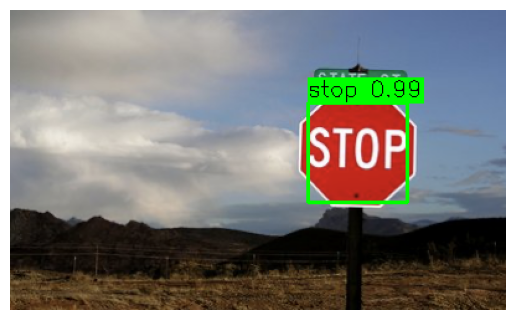

Time process:  2.9774928092956543
images/road415.png


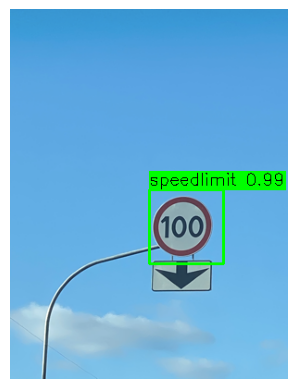

Time process:  4.959942579269409
images/road653.png


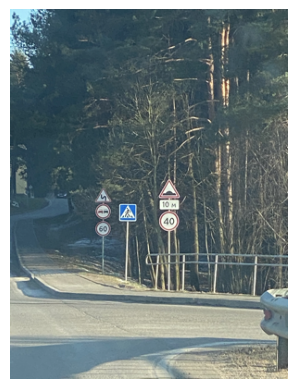

Time process:  5.317198276519775
images/road34.png


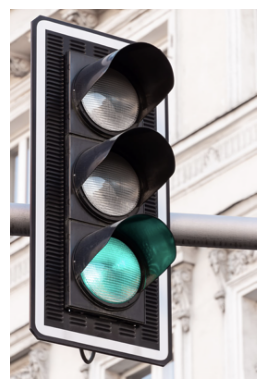

Time process:  8.901653289794922
images/road291.png


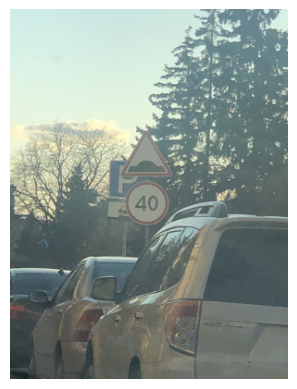

Time process:  11.090752840042114
images/road815.png


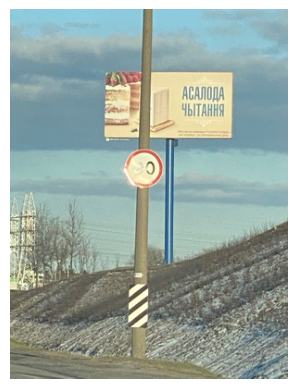

Time process:  8.987321853637695
images/road386.png


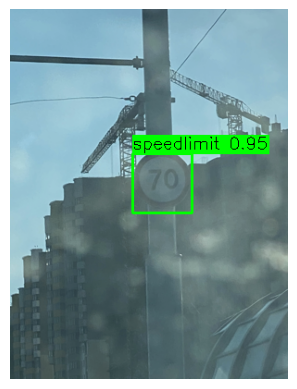

Time process:  4.761610507965088
images/road125.png


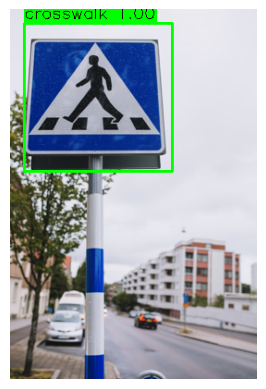

Time process:  3.257577419281006
images/road169.png


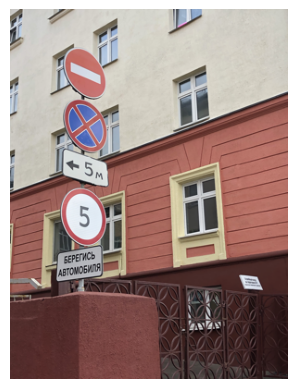

Time process:  3.8233916759490967
images/road709.png


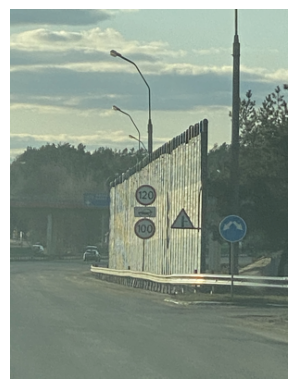

Time process:  4.642894268035889
images/road453.png


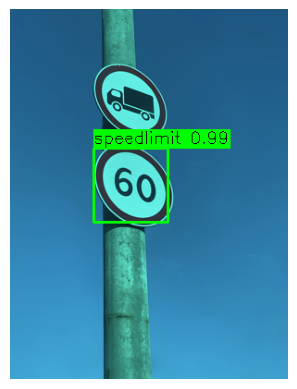

Time process:  3.8051273822784424
images/road635.png


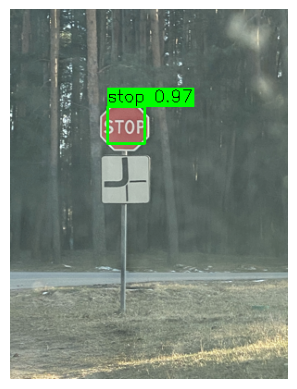

Time process:  4.064976692199707
images/road847.png


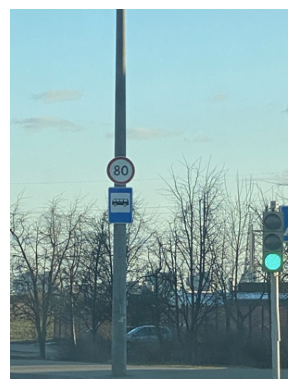

Time process:  4.442996263504028
images/road831.png


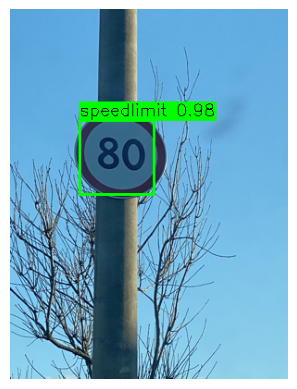

Time process:  3.9376275539398193
images/road389.png


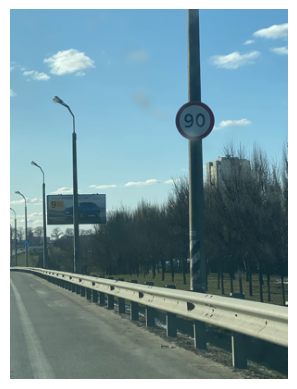

Time process:  3.876920700073242
images/road61.png


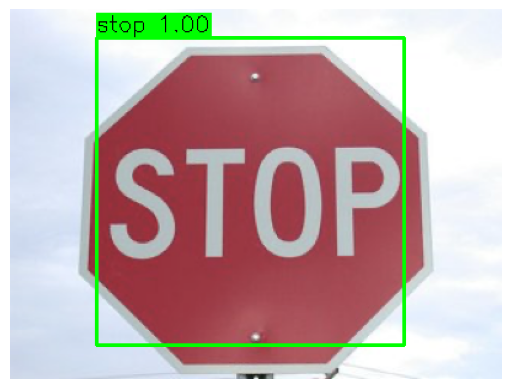

Time process:  4.175050497055054
images/road412.png


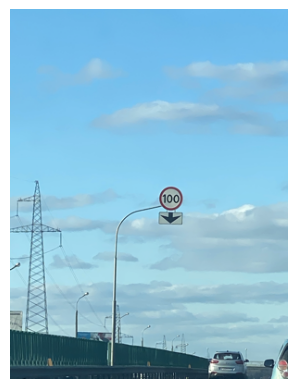

Time process:  4.225822925567627
images/road834.png


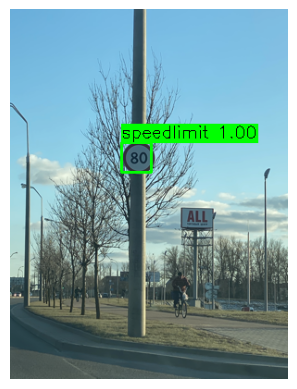

Time process:  3.722724199295044
images/road295.png


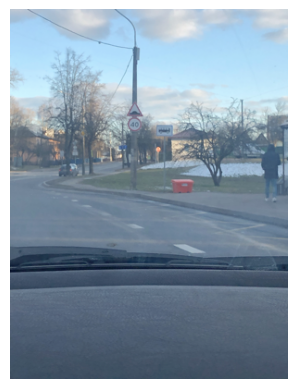

Time process:  3.770651340484619
images/road465.png


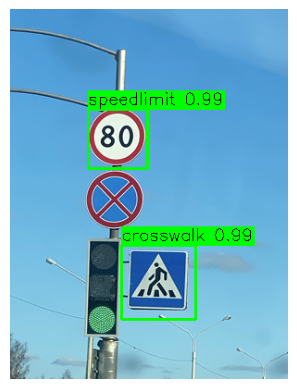

Time process:  4.591041326522827


In [136]:
import time

img_dir = 'images'
img_filename_lst = os.listdir(img_dir)[:20]
conf_threshold = 0.95
iou_threshold = 0.1
stride = 12
window_sizes = [
    (32, 32),
    (64, 64),
    (128, 128)
]

for img_filename in img_filename_lst:
    start_time = time.time()
    img_filepath = os.path.join(img_dir, img_filename)
    print(img_filepath)
    bboxes = []
    img = cv2.imread(img_filepath)
    pyramid_imgs = pyramid(img)

    for pyramid_img_info in pyramid_imgs:
        pyramid_img, scale_factor = pyramid_img_info
        window_lst = sliding_window(
            pyramid_img,
            window_sizes=window_sizes,
            stride=stride,
            scale_factor=scale_factor
        )
        for window in window_lst:
            xmin, ymin, xmax, ymax = window
            object_img = pyramid_img[ymin:ymax, xmin:xmax]
            preprocessed_img = preprocess_img(object_img)
            normalized_img = scaler.transform([preprocessed_img])[0]
            decision = clf.predict_proba([normalized_img])[0]
            if np.all(decision < conf_threshold):
                continue
            else:
                predict_id = np.argmax(decision)
                conf_score = decision[predict_id]
                xmin = int(xmin / scale_factor)
                ymin = int(ymin / scale_factor)
                xmax = int(xmax / scale_factor)
                ymax = int(ymax / scale_factor)
                bboxes.append(
                    [xmin, ymin, xmax, ymax, predict_id, conf_score]
                )
    bboxes = nms(bboxes, iou_threshold)
    visualize_bbox(img, bboxes, label_encoder)

    print('Time process: ', time.time() - start_time)